Import Libraries

In [117]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from yahoo_fin.stock_info import get_data
import plotly.graph_objs as go
import random

Selecting Stock

In [118]:
df = pd.DataFrame({"SYMBOL":["RELIANCE",
"TCS",
"HDFCBANK",
"ICICIBANK",
"HINDUNILVR",
"INFY",
"HDFC",
"ITC",
"SBIN",
"BHARTIARTL",
"KOTAKBANK",
"BAJFINANCE",
"LICI",
"LT",
"HCLTECH",
"ASIANPAINT",
"AXISBANK",
"MARUTI",
"SUNPHARMA",
"TITAN",
"DMART",
"ULTRACEMCO",
"BAJAJFINSV",
"WIPRO",
"ADANIENT",
"ONGC",
"NTPC",
"JSWSTEEL",
"POWERGRID",
"M&M",
"LTIM",
"TATAMOTORS",
"ADANIGREEN",
"ADANIPORTS",
"COALINDIA",
"TATASTEEL",
"HINDZINC",
"PIDILITIND",
"SIEMENS",
"ADANITRANS",
"SBILIFE",
"IOC",
"BAJAJ-AUTO",
"GRASIM",
"TECHM",
"HDFCLIFE",
"BRITANNIA",
"VEDL",
"GODREJCP",
"DABUR"]})

symbol=df["SYMBOL"][random.randint(0,50)]

Data and Graphs of Stock

In [119]:
symb=symbol+".NS"

data= get_data(symb, start_date="08/01/2018", end_date="08/31/2022", index_as_date = True, interval="1d")

print(symbol)
data

POWERGRID


,open,high,low,close,adjclose,volume,ticker
2018-08-01,137.250031,139.312531,135.112534,138.525040,105.123840,7724994,POWERGRID.NS
2018-08-02,139.612534,142.687531,138.562531,141.525040,107.400482,9229199,POWERGRID.NS
2018-08-03,142.350037,143.212540,141.750031,142.650040,108.254227,5618397,POWERGRID.NS
2018-08-06,143.887527,143.887527,141.487534,142.087540,107.827347,3708508,POWERGRID.NS
2018-08-07,142.387527,142.987534,140.737534,141.825027,107.628120,2452694,POWERGRID.NS
...,...,...,...,...,...,...,...
2022-08-24,227.350006,229.949997,226.500000,229.449997,218.923325,9755419,POWERGRID.NS
2022-08-25,230.500000,231.000000,225.100006,226.300003,215.917847,9093274,POWERGRID.NS
2022-08-26,226.600006,231.199997,226.600006,230.449997,219.877457,5974534,POWERGRID.NS
2022-08-29,228.250000,228.899994,225.600006,227.050003,216.633453,5637760,POWERGRID.NS


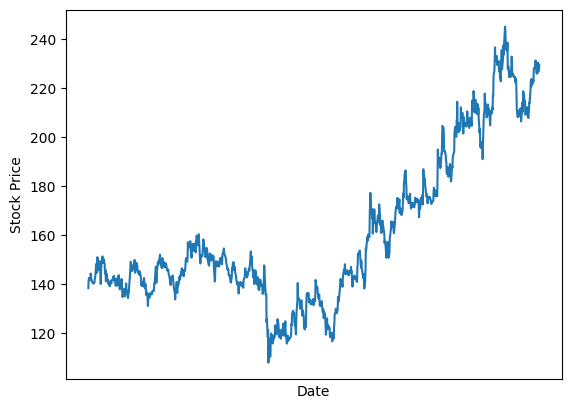

In [120]:
plt.plot(data['close'], label='Price')
plt.tick_params(axis="x",bottom=False,labelbottom=False)
plt.ylabel("Stock Price")
plt.xlabel("Date")
plt.show()

In [121]:
fig = go.Figure()

fig.add_trace(go.Candlestick(x=data.index,
                             open=data['open'],
                             high=data['high'],
                             low=data['low'],
                             close=data['close'], name='market data'))

fig.update_layout(
    title=f'{symbol} share price evolution',
    yaxis_title='Stock Price (INR per Shares)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3 month", step="month", stepmode="backward"),
            dict(count=6, label="6 month", step="month", stepmode="backward"),
            dict(count=9, label="9 month", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()


*STRATERGIES*

1) The On-Balance-volume indicator (OBV)

The On-Balance-Volume is a technical analysis indicator used to measure the positive and negative flow of volume in a security over time. It is a momentum indicator that measures positive and negative volume flow.

This indicator was developed by Joseph Granville. According to him, when volume increases sharply without a significant change in the stock’s price then the price will eventually jump up and when volume decreases sharply without a significant change in the stock’s price then the price will eventually jump down.

Calculation:
There are three rules implemented when calculating on-balance volume (OBV):
1) If today’s closing price is higher than yesterday’s closing price
Current OBV = Previous OBV + today’s volume
2) If today’s closing price is lower than yesterday’s closing price
 Current OBV = Previous OBV – today’s volume
3) If today’s closing price equals yesterday’s closing price
 Current OBV = Previous OBV


In [122]:
def OBV_trading_bot(data, initial_portfolio=100000, stop_loss=0.05, commission=20):

    shares_owned = 0
    cash = initial_portfolio
    buy_price = 0
    sell_price = 0
    stop_loss_price = 0
    trade_count=0

    data['OBV'] = np.where(data['close'] > data['close'].shift(1), data['volume'],
                           np.where(data['close'] < data['close'].shift(1), -data['volume'], 0)).cumsum()

    for i in range(1, len(data)):

        if data['OBV'][i] > data['OBV'][i-1] and cash > 0:
            shares_to_buy = cash // (data['close'][i] + commission)
            buy_price = data['close'][i]
            shares_owned += shares_to_buy
            cash -= shares_to_buy * buy_price
            cash -= commission
            trade_count += 1
            stop_loss_price = buy_price - (buy_price * stop_loss)

        elif data['OBV'][i] < data['OBV'][i-1] and shares_owned > 0:
            sell_price = data['close'][i]
            cash += shares_owned * sell_price
            cash -= commission
            trade_count += 1
            shares_owned = 0
            stop_loss_price = 0

        elif data['close'][i] < stop_loss_price and shares_owned > 0:
            sell_price = stop_loss_price
            cash += shares_owned * sell_price
            cash -= commission
            trade_count += 1
            shares_owned = 0
            stop_loss_price = 0

    final_portfolio = cash + (shares_owned * data['close'][-1])
    print(f'Final portfolio value: Rs. {final_portfolio:.2f}')
    print("Total trades: {0}".format(trade_count))


OBV_trading_bot(data)

Final portfolio value: Rs. 63614.62
Total trades: 751


2) The Accumulation/Distribution line (A/D line)

In [123]:
def ad_line(data):
    adl = pd.Series(0.0, index=data.index)
    adl.iloc[0] = ((data['close'].iloc[0] - data['low'].iloc[0]) - (data['high'].iloc[0] - data['close'].iloc[0])) / (data['high'].iloc[0] - data['low'].iloc[0]) * data['volume'].iloc[0]
    for i in range(1, len(data)):
        if data['close'].iloc[i] > data['close'].iloc[i-1]:
            mf = ((data['close'].iloc[i] - data['low'].iloc[i]) - (data['high'].iloc[i] - data['close'].iloc[i])) / (data['high'].iloc[i] - data['low'].iloc[i]) * data['volume'].iloc[i]
        else:
            mf = ((data['close'].iloc[i] - data['high'].iloc[i]) - (data['low'].iloc[i] - data['close'].iloc[i])) / (data['high'].iloc[i] - data['low'].iloc[i]) * data['volume'].iloc[i]
        adl.iloc[i] = adl.iloc[i-1] + mf
    return adl

def AD_Line_trading_bot(data, portfolio=100000, stop_loss=0.05, commission=20):
    data['adl'] = ad_line(data)

    data['buy_signal'] = np.where(data['adl'] > data['adl'].shift(1), 1, 0)
    data['sell_signal'] = np.where(data['adl'] < data['adl'].shift(1), 1, 0)

    shares = 0
    trade_count = 0
    for i in range(1, len(data)):
        if data['sell_signal'].iloc[i] == 1:
            if shares > 0:
                portfolio += shares * data['close'].iloc[i] - commission
                shares = 0
                trade_count += 1

        if data['buy_signal'].iloc[i] == 1:
            if shares == 0:
                shares = portfolio // data['close'].iloc[i]
                portfolio -= shares * data['close'].iloc[i] + commission
                trade_count += 1

        if shares > 0 and data['close'].iloc[i] < (1 - stop_loss) * data['close'].iloc[0]:
            portfolio += shares * data['close'].iloc[i] - commission
            shares = 0
            trade_count += 1

    if shares > 0:
        portfolio += shares * data['close'].iloc[-1]
        final_portfolio = portfolio

    print("Final portfolio value: Rs. {0:.2f}".format(final_portfolio))
    print("Total trades: {0}".format(trade_count))

AD_Line_trading_bot(data)

Final portfolio value: Rs. 62316.66
Total trades: 547


3) Moving Average Convergence Divergence (MACD) Indicator

In [124]:
def MACD_trading_bot(df, portfolio_value=100000, stop_loss=0.05, commission=20):
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9, adjust=False).mean()

    position = 0
    trade_count = 0

    for i in range(len(df)):
        price = df['close'][i]
        macd_val = macd[i]
        signal_val = signal[i]

        if macd_val > signal_val and position == 0:
            shares_to_buy = np.floor(portfolio_value / price)
            cost = shares_to_buy * price + 20
            portfolio_value -= cost
            portfolio_value -= commission
            position = shares_to_buy
            trade_count += 1

        elif macd_val < signal_val and position > 0:
            sale_price = price * position
            portfolio_value += sale_price
            portfolio_value -= commission
            position = 0
            trade_count += 1

        elif position > 0 and price < (1 - stop_loss) * df['close'][i-1]:
            sale_price = price * position
            portfolio_value += sale_price
            portfolio_value -= commission
            position = 0
            trade_count += 1

    print(f'Final portfolio value: Rs. {portfolio_value:.2f}')
    print("Total trades: {0}".format(trade_count))

MACD_trading_bot(data)


Final portfolio value: Rs. 131995.76
Total trades: 76


4) The Stochastic Oscillator

In [125]:
def SO_trading_bot(df, portfolio_value=100000, stop_loss=0.05, commission=20):
    window_length = 14
    high = df['high'].rolling(window_length).max()
    low = df['low'].rolling(window_length).min()
    k = 100 * (df['close'] - low) / (high - low)
    d = k.rolling(3).mean()

    position = 0
    trade_count = 0

    for i in range(len(df)):
        price = df['close'][i]
        k_val = k[i]
        d_val = d[i]

        if k_val < 20 and d_val < 50 and position == 0:
            shares_to_buy = np.floor(portfolio_value / price)
            cost = shares_to_buy * price
            portfolio_value -= cost
            portfolio_value-=commission
            position = shares_to_buy
            trade_count += 1

        elif k_val > 80 and d_val > 50 and position > 0:
            sale_price = price * position
            portfolio_value += sale_price
            portfolio_value-=commission
            position = 0
            trade_count += 1

        elif position > 0 and price < (1 - stop_loss) * df['close'][i-1]:
            sale_price = price * position
            portfolio_value += sale_price
            portfolio_value-=commission
            position = 0
            trade_count += 1

    print(f'Final portfolio value: Rs. {portfolio_value:.2f}')
    print("Total trades: {0}".format(trade_count))

SO_trading_bot(data)

Final portfolio value: Rs. 211265.24
Total trades: 60


5) Parabolic SAR [Our Indicator]

    The Parabolic SAR (Stop and Reverse) strategy is a technical analysis tool that helps traders identify potential entry and exit points in a market. It is based on the use of a parabolic SAR indicator, which is represented by a series of dots on a price chart.

    The parabolic SAR indicator is calculated based on the price and time, and it is designed to follow the price trend of an asset. When the price of an asset is rising, the parabolic SAR dots will be below the price, and when the price is falling, the dots will be above the price.

    The basic strategy using the parabolic SAR is to buy when the dots are below the price and sell when the dots are above the price. Traders can also use the dots to set stop loss orders to protect their positions.

    Here are the steps to implement a Parabolic SAR strategy:
    1)Identify the trend: Use the parabolic SAR dots to determine the direction of the trend. If the dots are below the price, the trend is up. If the dots are above the price, the trend is down.
    2)Enter a trade: Once you have identified the trend, enter a trade in the direction of the trend when the price crosses above or below the parabolic SAR dot.
    3)Set stop loss: Use the parabolic SAR dots to set a stop loss order to protect your position. Place the stop loss below the dot when you are long, and above the dot when you are short.
    4)Exit the trade: When the price crosses the parabolic SAR dot in the opposite direction of the trend, it may be time to exit the trade.



In [126]:
def Parabolic_SAR_trading_bot(df, portfolio_value=100000, stop_loss=0.15,commission=20):
    trade_count = 0

    af = 0.02
    max_af = 0.2
    prev_sar = df['low'][0]
    prev_ep = df['high'][0]
    prev_af = af
    sar_values = [prev_sar]

    for i in range(1, len(df)):
        curr_high = df['high'][i]
        curr_low = df['low'][i]
        curr_sar = prev_sar + prev_af * (prev_ep - prev_sar)

        if curr_sar > curr_low:
            curr_sar = curr_low
        elif curr_sar < prev_ep:
            curr_sar = prev_ep

        if curr_high > prev_ep:
            curr_ep = curr_high
            curr_af = min(prev_af + af, max_af)
        else:
            curr_ep = prev_ep
            curr_af = prev_af

        sar_values.append(curr_sar)

        prev_sar = curr_sar
        prev_ep = curr_ep
        prev_af = curr_af

    df['SAR'] = sar_values

    position = 0

    for i in range(len(df)):
        price = df['close'][i]
        sar_val = df['SAR'][i]

        if price > sar_val and position == 0:
            shares_to_buy = np.floor(portfolio_value / price)
            cost = shares_to_buy * price
            portfolio_value -= cost
            portfolio_value -= commission
            position = shares_to_buy
            trade_count += 1

        elif price < sar_val and position > 0:
            sale_price = price * position - 20
            portfolio_value += sale_price
            portfolio_value -= commission
            position = 0
            trade_count += 1

        elif position > 0 and price < (1 - stop_loss) * df['close'][i-1]:
            sale_price = price * position - 20
            portfolio_value += sale_price
            portfolio_value -= commission
            trade_count += 1
            position = 0
    portfolio_value += (position * df['close'][-1])
    print(f'Final portfolio value: Rs. {portfolio_value:.2f}')
    print("Total trades: {0}".format(trade_count))

Parabolic_SAR_trading_bot(data)

Final portfolio value: Rs. 204975.97
Total trades: 137


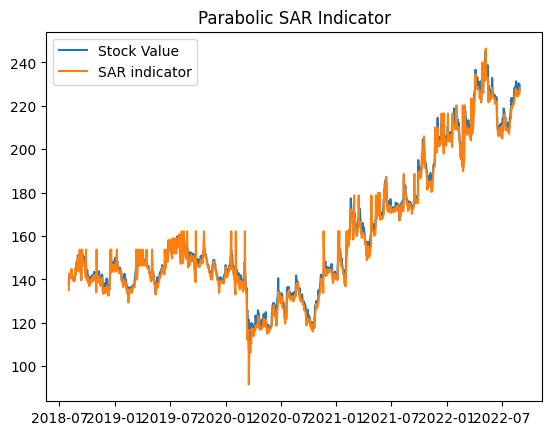

In [127]:
plt.plot(data['close'],label="Stock Value")
plt.plot(data['SAR'],label="SAR indicator")
plt.title('Parabolic SAR Indicator')
plt.legend()
plt.show()

NIFTY 50

In [128]:


data = get_data("^NSEI", start_date="08/01/2018",
                end_date="08/31/2022", index_as_date=True, interval="1d")
(Parabolic_SAR_trading_bot(data))


Final portfolio value: Rs. 141206.77
Total trades: 161
